# Tolerance Regions: A synthetic example (based on [1])

In this tutorial we will create synthetic 1-dimensional heteroscedastic data, and use the conformalized quantile regression (CQR) [1] to create a tolerance region. The regression function used in this experiment is random forests.

[1] Yaniv Romano, Evan Patterson, and Emmanuel J. Candes, “Conformalized quantile regression.” 2019. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub/dissertation

Mounted at /content/drive
/content/drive/MyDrive/GitHub/dissertation


In [ ]:
!pip install scikit-garden
!pip install scikit-learn==0.21.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 317 kB 8.1 MB/s 
  Created wheel for scikit-garden: filename=scikit_garden-0.1.3-cp37-cp37m-linux_x86_64.whl size=671891 sha256=e5cf7a114d5b3083a9d32b9fbcd3937642bc68e87f3e51efcdf42371d5105019
  Stored in directory: /root/.cache/pip/wheels/10/06/27/3687df098199aadafad4cb3061bd59e86d3e4bb7428edd0d66
Successfully built scikit-garden
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 6.2 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requi

We start by defining the desired parameters, and some hyper-parameters of random forests. These parameters are used by the conditional quantile random forests regression. 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.cp import IcpRegressor
from nonconformist.nc import QuantileRegErrFunc
import timeit
import random
import torch
from scipy.stats import binom, beta, betabinom
from statsmodels.distributions.empirical_distribution import ECDF

cqr_color = '#1f77b4'
beta_binom_color = '#ff7f0e'
beta_color = '#2ca02c'
qr_color = '#d62728'

%matplotlib inline

seed = 23
#seed = 19
#seed = 17
#seed = 13
#seed = 11
#seed = 7
#seed = 5
#seed = 3
#seed = 2
#seed = 1

# number of datapoints
n_train = 1000
n_cal = 1000
n_test = 5000

# desired tolerance region 
eps = 0.1
delta = 0.1

# number of loops
R = 1000

# desired expected miscoverage error
alpha = (max(np.where(binom.cdf(range(n_cal), n_cal, eps)<=delta)[-1])+1)/(n_cal+1)

# low and high target quantiles
quantiles = [100*alpha/2, 100*(1-alpha/2)]

# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = 100
params_qforest["min_samples_leaf"] = 40
params_qforest["max_features"] = 1
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = seed
params_qforest["range_vals"] = 30
params_qforest["num_vals"] = 10

# maximal number of testpoints to plot
max_show = 1000

# save figures and runs?
save_figures = True
save_run = True

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

The following graph function plots the test data and saves to drive

In [ ]:
def plot_func(x,
              y,
              y_u=None,
              y_l=None,
              pred=None,
              shade_color="",
              method_name="",
              title="",
              filename=None,
              save_figures=False):
    
    """ Scatter plot of (x,y) points along with the constructed prediction interval 
    
    Parameters
    ----------
    x : numpy array, corresponding to the feature of each of the n samples
    y : numpy array, target response variable (length n)
    pred : numpy array, the estimated prediction. It may be the conditional mean,
           or low and high conditional quantiles.
    shade_color : string, desired color of the prediciton interval
    method_name : string, name of the method
    title : string, the title of the figure
    filename : sting, name of the file to save the figure
    save_figures : boolean, save the figure (True) or not (False)
    
    """
    
    x_ = x[:max_show]
    y_ = y[:max_show]
    if y_u is not None:
        y_u_ = y_u[:max_show]
    if y_l is not None:
        y_l_ = y_l[:max_show]
    if pred is not None:
        pred_ = pred[:max_show]

    fig = plt.figure()
    inds = np.argsort(np.squeeze(x_))
    plt.plot(x_[inds,:], y_[inds], 'k.', alpha=.2, markersize=10,
             fillstyle='none', label=u'Observations')
    
    if (y_u is not None) and (y_l is not None):
        plt.fill(np.concatenate([x_[inds], x_[inds][::-1]]),
                 np.concatenate([y_u_[inds], y_l_[inds][::-1]]),
                 alpha=.5, fc=shade_color, ec='None',
                 label = method_name + ' prediction interval')
    
    if pred is not None:
        if pred_.ndim == 2:
            plt.plot(x_[inds,:], pred_[inds,0], 'k', lw=2, alpha=0.9,
                     label=u'QR predicted quantiles')
            plt.plot(x_[inds,:], pred_[inds,1], 'k', lw=2, alpha=0.9)
        else:
            plt.plot(x_[inds,:], pred_[inds], 'k--', lw=2, alpha=0.9,
                     label=u'Predicted value')
    
    plt.ylim([-2.5, 7])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper right')
    if save_figures and (filename is not None):
        plt.savefig(filename, bbox_inches='tight', dpi=300)
    
    plt.show()

## **Synthetic data example**

Here we generate our training and test samples $(X_i,Y_i)$. To generate the training data, we draw $n=2000$ independent, univariate predictor samples $X_i$ from the uniform distribution on the interval $[1,5]$. The response variable is then sampled as $$ Y_i \sim \textrm{Pois}(\sin^2(X_i) + 0.1) + 0.03 X_i \epsilon_{1,i} + 25 \mathbb{1}\{ U_i < 0.01 \} \epsilon_{2,i},$$ where $\textrm{Pois}(\lambda)$ is the Poisson distribution with mean $\lambda$, both $\epsilon_{1,i}$ and $\epsilon_{2,i}$ are i.i.d.\ standard Gaussian noise, and the $U_i$ are uniform on the interval $[0,1]$. The last term in the equation above creates a few but large outliers. We generate a test set of 5000 samples in the same way.

In [ ]:
def f(x):
    ''' Construct data (1D example)
    '''
    ax = 0*x
    for i in range(len(x)):
        ax[i] = np.random.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*np.random.randn(1)
        ax[i] += 25*(np.random.uniform(0,1,1)<0.01)*np.random.randn(1)
    return ax.astype(float)

Generate and plot data

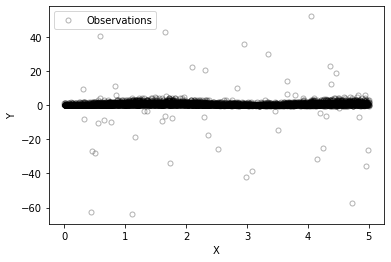

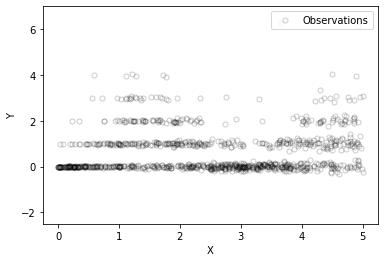

In [ ]:
np.random.seed(seed)
  
# training calibration and test features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
x_cal = np.random.uniform(0, 5.0, size=n_cal).astype(float)
x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

# generate labels
y_train = f(x_train)
y_cal = f(x_cal)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train, 1))
x_cal = np.reshape(x_cal,(n_cal, 1))
x_test = np.reshape(x_test,(n_test, 1))

# display the test data in full range (including the outliers)
fig = plt.figure()
plt.plot(x_test, y_test, 'k.', alpha = 0.3, markersize=10,
         fillstyle='none', label=u'Observations')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
if save_figures:
    plt.savefig("Images/test_data.png",
                bbox_inches='tight', dpi=300)
plt.show()

# display the test data without outliers (zoom in)
plot_func(x_test,y_test,filename="Images/test_data_zoom.png", save_figures=save_figures)

Fit base predictor

In [ ]:
start = timeit.default_timer()

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(x_train, y_train)

# compute the absolute errors on calibration data
icp.calibrate(x_cal, y_cal)

# produce predictions for the test set, with confidence equal to significance
predictions = icp.predict(x_test, significance=alpha)
y_lower = predictions[:,0]
y_upper = predictions[:,1]

# compute the low and high conditional quantile estimation
pred_qr = quantile_estimator.predict(x_test)
y_lower_qr = pred_qr[:,0]
y_upper_qr = pred_qr[:,1]

stop = timeit.default_timer()
print('CQR + QR QRF: Time: ', stop - start)

CQR + QR QRF: Time:  24.276406167999966


Estimate performance of CQR and base predictor on test set, together with interval length and estimate of lambda. Visualize with graphs

CQR QRF: Percentage in the range (expecting 91.20879120879121%): 92.25999999999999
QR QRF : Percentage in the range (expecting 82.08791208791209%): 83.98
CQR QRF: Average length: 2.0875833736021674
QR QRF : Average length: 1.9697355958667286
CQR QRF: Lambda: 0.05892388886771949


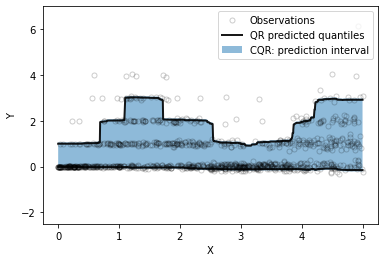

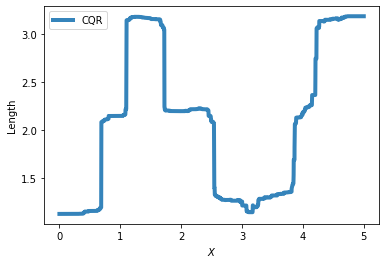

In [ ]:
# compute and display the average coverage
in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
in_the_range_qr = np.sum((y_test >= y_lower_qr) & (y_test <= y_upper_qr))
print("CQR QRF: Percentage in the range (expecting " + str(100*(1-alpha)) + "%):",
      in_the_range / len(y_test) * 100)
print("QR QRF : Percentage in the range (expecting " + str(100*(1-alpha)*params_qforest["coverage_factor"]) + "%):",
      in_the_range_qr / len(y_test) * 100)

# compute length of the conformal interval per each test point
length_cqr_rf = y_upper - y_lower
length_qr_rf = y_upper_qr - y_lower_qr

# compute and display the average length
print("CQR QRF: Average length:", np.mean(length_cqr_rf))
print("QR QRF : Average length:", np.mean(length_qr_rf))

# compute and display the value of lambda
print("CQR QRF: Lambda:", y_upper[0]-y_upper_qr[0])

# display the results
plot_func(x=x_test,y=y_test,y_u=y_upper,y_l=y_lower,pred=pred_qr,shade_color=cqr_color,
          method_name="CQR:", filename="Images/cqr.png",save_figures=save_figures)

# Display length of interval as function of X
fig = plt.figure()
inds = np.argsort(np.squeeze(x_test))

plt.plot(x_test[inds,:], length_cqr_rf[inds], cqr_color, lw=4, label=u'CQR', alpha=0.9)

plt.xlabel('$X$')
plt.ylabel('Length')
plt.legend(loc='upper left')
if save_figures:
    plt.savefig("Images/cqr_length.png", bbox_inches='tight', dpi=300)
plt.show()

## **QRF and CQR 1 predictor simultaenously (NOT USED IN FINAL DRAFT)**

Here we fit $R=1000$ trials of QRF and CQR procedure using the same proper training set for each trial. We start with the hyperparameters

In [ ]:
# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = 100
params_qforest["min_samples_leaf"] = 40
params_qforest["max_features"] = 1
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = seed
params_qforest["range_vals"] = 30
params_qforest["num_vals"] = 10

# define quantile random forests (QRF) parameters
params_qforest_qrf = dict()
params_qforest_qrf["n_estimators"] = 100
params_qforest_qrf["min_samples_leaf"] = 40
params_qforest_qrf["max_features"] = 1
params_qforest_qrf["CV"] = False
params_qforest_qrf["random_state"] = seed

Fit base predictor

In [ ]:
np.random.seed(seed)

start = timeit.default_timer()

# training features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

# generate labels
y_train = f(x_train)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train, 1))
x_test = np.reshape(x_test,(n_test,1))

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(x_train, y_train)

# compute the low and high conditional quantile estimation
pred_qr_qrf = quantile_estimator.predict(x_test)
y_lower_qr_qrf = pred_qr_qrf[:,0]
y_upper_qr_qrf = pred_qr_qrf[:,1]

# compute and display the average coverage
in_the_range_qr_qrf = np.sum((y_test >= y_lower_qr_qrf) & (y_test <= y_upper_qr_qrf))
print("QR QRF : Pct in range (expecting " + str(100*(1-alpha)*params_qforest["coverage_factor"]) + "%):", in_the_range_qr_qrf / len(y_test) * 100)

# compute and display length of the conformal interval per each test point
length_qr_qrf = y_upper_qr_qrf - y_lower_qr_qrf
print("QR QRF : Average length:", np.mean(length_qr_qrf))

stop = timeit.default_timer()
print('QR QRF: Time: ', stop - start)

QR QRF : Pct in range (expecting 82.08791208791209%): 83.38
QR QRF : Average length: 1.9404034499163099
QR QRF: Time:  20.94709387599869


Define loop for CQR procedure

In [ ]:
def cqr_loop(
      R = 100,
      n_cal = 100,
      n_test = 100,
      alpha = 0.05,
      save_run = False,
      filename = None):

    results = np.array([[0]*5]*R, dtype=float)

    for i in range(R):

        start = timeit.default_timer()

        # calibration and test features
        x_cal = np.random.uniform(0, 5.0, size=n_cal).astype(float)
        x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

        # generate labels
        y_cal = f(x_cal)
        y_test = f(x_test)

        # reshape the features
        x_cal = np.reshape(x_cal,(n_cal, 1))  
        x_test = np.reshape(x_test,(n_test,1))

        # compute the absolute errors on calibration data
        icp.calibrate(x_cal, y_cal)

        # produce predictions for the test set, with confidence equal to significance
        predictions = icp.predict(x_test, significance=alpha)
        y_lower = predictions[:,0]
        y_upper = predictions[:,1]

        # fit QRF base predictor with combined proper train and calibration data
        qrf = helper.QuantileForestRegressorAdapter(model=None,
                                                    fit_params=None,
                                                    quantiles=quantiles,
                                                    params=params_qforest_qrf)
        nc_qrf = RegressorNc(qrf, QuantileRegErrFunc())
        icp_qrf = IcpRegressor(nc_qrf)
        icp_qrf.fit(np.reshape(np.append(x_train, x_cal), (n_train+n_cal, 1)), np.reshape(np.append(y_train, y_cal), (n_train+n_cal, 1)))
        predictions_qrf = qrf.predict(x_test)
        y_lower_qrf = predictions_qrf[:,0]
        y_upper_qrf = predictions_qrf[:,1]

        # compute and display the average coverage
        in_the_range = np.sum((y_test >= y_lower) & (y_test <= y_upper))
        in_the_range_qrf = np.sum((y_test >= y_lower_qrf) & (y_test <= y_upper_qrf))
        print("CQR: Pct in range (expecting " + str(100*(1-alpha)) + "%):", in_the_range / len(y_test) * 100)
        print("QRF: Pct in range (expecting " + str(100*(1-alpha)) + "%):", in_the_range_qrf / len(y_test) * 100)
        results[i][0] = in_the_range / len(y_test) * 100
        results[i][3] = in_the_range_qrf / len(y_test) * 100

        # compute length of the conformal interval per each test point
        length = y_upper - y_lower
        length_qrf = y_upper_qrf - y_lower_qrf

        # compute and display the average length
        print("CQR: Average length:", np.mean(length))
        print("QRF: Average length:", np.mean(length_qrf))
        results[i][1] = np.mean(length)
        results[i][4] = np.mean(length_qrf)

        stop = timeit.default_timer()
        print('CQR: Runtime: ', stop - start)
        results[i][2] = stop - start
    
    results = pd.DataFrame(results,
                           columns = ['CQR Pct in range', 'CQR Avg length', 'Runtime', 'QRF Pct in range', 'QRF Avg length'])
    
    if save_run and (filename is not None):
      results.to_csv(filename, index=False)

    return(results)

Fit $R=1000$ runs and save results to drive

In [ ]:
np.random.seed(seed)

run = cqr_loop(
      R = R,
      n_cal = n_cal,
      n_test = n_test,
      alpha = alpha,
      save_run = save_run,
      filename = "Experiments Output/toy3_s19_R1000.csv")

CQR: Pct in range (expecting 91.20879120879121%): 88.96
QRF: Pct in range (expecting 91.20879120879121%): 89.56
CQR: Average length: 1.9964384269136932
QRF: Average length: 2.330000908699432
CQR: Runtime:  20.563138009001705
CQR: Pct in range (expecting 91.20879120879121%): 92.67999999999999
QRF: Pct in range (expecting 91.20879120879121%): 90.16
CQR: Average length: 2.0955594831113253
QRF: Average length: 2.2504400870115195
CQR: Runtime:  21.76922945000115
CQR: Pct in range (expecting 91.20879120879121%): 90.10000000000001
QRF: Pct in range (expecting 91.20879120879121%): 89.62
CQR: Average length: 2.0351115236132946
QRF: Average length: 2.2193499892028368
CQR: Runtime:  21.19914559300014
CQR: Pct in range (expecting 91.20879120879121%): 91.4
QRF: Pct in range (expecting 91.20879120879121%): 89.05999999999999
CQR: Average length: 2.082183205361648
QRF: Average length: 2.3403520030060907
CQR: Runtime:  21.90521479399831
CQR: Pct in range (expecting 91.20879120879121%): 92.44
QRF: Pct i

## **Quantile Random Forest (QRF)**
Fit $R=1000$ QRF on combined proper training and calibration set. This predictor does not have a finite sample guarantee. The results are used to compare QRF to CQR.

In [ ]:
# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = 100
params_qforest["min_samples_leaf"] = 40
params_qforest["max_features"] = 1
params_qforest["CV"] = False
params_qforest["random_state"] = seed

In [ ]:
def qrf_loop(
      R = 100,
      n_train = 100,
      n_test = 100,
      alpha = 0.05,
      save_run = False,
      filename = None):

    results = np.array([[0]*3]*R, dtype=float)

    for i in range(R):

        start = timeit.default_timer()

        # training calibration and test features
        x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
        x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

        # generate labels
        y_train = f(x_train)
        y_test = f(x_test)

        # reshape the features
        x_train = np.reshape(x_train,(n_train, 1))
        x_test = np.reshape(x_test,(n_test, 1))

        # define the QRF model
        quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

        # fit the conditional quantile regression to the proper training data
        quantile_estimator.fit(x_train, y_train)

        # compute the low and high conditional quantile estimation
        pred_qr = quantile_estimator.predict(x_test)
        y_lower_qr = pred_qr[:,0]
        y_upper_qr = pred_qr[:,1]

        # compute and display the average coverage
        in_the_range_qr = np.sum((y_test >= y_lower_qr) & (y_test <= y_upper_qr))
        print("QR QRF : Pct in range (expecting " + str(100*(1-alpha)*params_qforest["coverage_factor"]) + "%):",
              in_the_range_qr / len(y_test) * 100)
        results[i][0] = in_the_range_qr / len(y_test) * 100

        # compute length of the conformal interval per each test point
        length_qr_rf = y_upper_qr - y_lower_qr
        print("QR QRF : Average length:", np.mean(length_qr_rf))
        results[i][1] = np.mean(length_qr_rf)

        stop = timeit.default_timer()
        print('QR QRF : Runtime: ', stop - start)
        results[i][2] = stop - start
    
    results = pd.DataFrame(results,
                           columns = ['QR Pct in range', 'QR Avg length', 'Runtime'])
    
    if save_run and (filename is not None):
      results.to_csv(filename, index=False)

    return(results)

In [ ]:
np.random.seed(seed)

run = qrf_loop(
      R = R,
      n_train = n_train+n_cal,
      n_test = n_test,
      alpha = alpha,
      save_run = save_run,
      filename = "Experiments Output/toy_qrf_s23_R1000.csv")

QR QRF : Pct in range (expecting 91.20879120879121%): 90.24
QR QRF : Average length: 2.285731692099384
QR QRF : Runtime:  11.94869684599999
QR QRF : Pct in range (expecting 91.20879120879121%): 90.58
QR QRF : Average length: 2.418481721268504
QR QRF : Runtime:  11.941096606000002
QR QRF : Pct in range (expecting 91.20879120879121%): 89.82
QR QRF : Average length: 2.3581724423659356
QR QRF : Runtime:  12.016989051999985
QR QRF : Pct in range (expecting 91.20879120879121%): 89.98
QR QRF : Average length: 2.3924983472183774
QR QRF : Runtime:  12.018348469000017
QR QRF : Pct in range (expecting 91.20879120879121%): 90.84
QR QRF : Average length: 2.367103494395127
QR QRF : Runtime:  12.173513461999988
QR QRF : Pct in range (expecting 91.20879120879121%): 90.36
QR QRF : Average length: 2.4783411547990735
QR QRF : Runtime:  13.51237711600001
QR QRF : Pct in range (expecting 91.20879120879121%): 90.60000000000001
QR QRF : Average length: 2.440089951147037
QR QRF : Runtime:  12.141693674999999


## **CQR Tolerance Regions (1 predictor) (NOT USED IN FINAL DRAFT)**

Fit 1 predictor, repeat calibration and test procedure R times

In [ ]:
# define quantile random forests (QRF) parameters
params_qforest = dict()
params_qforest["n_estimators"] = 100
params_qforest["min_samples_leaf"] = 40
params_qforest["max_features"] = 1
params_qforest["CV"] = True
params_qforest["coverage_factor"] = 0.9
params_qforest["test_ratio"] = 0.1
params_qforest["random_state"] = seed
params_qforest["range_vals"] = 30
params_qforest["num_vals"] = 10

In [ ]:
np.random.seed(seed)

start = timeit.default_timer()

# training features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

# generate labels
y_train = f(x_train)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train, 1))
x_test = np.reshape(x_test,(n_test,1))

# define the QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated QRF band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# build the split CQR object
icp = IcpRegressor(nc)

# fit the conditional quantile regression to the proper training data
icp.fit(x_train, y_train)

# compute the low and high conditional quantile estimation
pred_qr_qrf = quantile_estimator.predict(x_test)
y_lower_qr_qrf = pred_qr_qrf[:,0]
y_upper_qr_qrf = pred_qr_qrf[:,1]

# compute and display the average coverage
in_the_range_qr_qrf = np.sum((y_test >= y_lower_qr_qrf) & (y_test <= y_upper_qr_qrf))
print("QR QRF : Pct in range (expecting " + str(100*(1-alpha)*params_qforest["coverage_factor"]) + "%):", in_the_range_qr_qrf / len(y_test) * 100)

# compute and display length of the conformal interval per each test point
length_qr_qrf = y_upper_qr_qrf - y_lower_qr_qrf
print("QR QRF : Average length:", np.mean(length_qr_qrf))

stop = timeit.default_timer()
print('QR QRF: Time: ', stop - start)

QR QRF : Pct in range (expecting 82.08791208791209%): 88.22
QR QRF : Average length: 2.238784660092443
QR QRF: Time:  10.657129113002156


In [ ]:
def cqr_loop(
      R = 100,
      n_cal = 100,
      n_test = 100,
      alpha = 0.05,
      save_run = False,
      filename = None):

    results = np.array([[0]*3]*R, dtype=float)

    for i in range(R):

        start = timeit.default_timer()

        # calibration and test features
        x_cal = np.random.uniform(0, 5.0, size=n_cal).astype(float)
        x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

        # generate labels
        y_cal = f(x_cal)
        y_test = f(x_test)

        # reshape the features
        x_cal = np.reshape(x_cal,(n_cal, 1))  
        x_test = np.reshape(x_test,(n_test,1))

        # compute the absolute errors on calibration data
        icp.calibrate(x_cal, y_cal)

        # produce predictions for the test set, with confidence equal to significance
        predictions = icp.predict(x_test, significance=alpha)
        y_lower = predictions[:,0]
        y_upper = predictions[:,1]

        # compute and display the average coverage
        in_the_range_cqr_qrf = np.sum((y_test >= y_lower) & (y_test <= y_upper))
        print("CQR QRF: Pct in range (expecting " + str(100*(1-alpha)) + "%):", in_the_range_cqr_qrf / len(y_test) * 100)
        results[i][0] = in_the_range_cqr_qrf / len(y_test) * 100

        # compute length of the conformal interval per each test point
        length_cqr_qrf = y_upper - y_lower

        # compute and display the average length
        print("CQR QRF: Average length:", np.mean(length_cqr_qrf))
        results[i][1] = np.mean(length_cqr_qrf)

        stop = timeit.default_timer()
        print('CQR QRF: Runtime: ', stop - start)
        results[i][2] = stop - start
    
    results = pd.DataFrame(results,
                           columns = ['CQR Pct in range', 'CQR Avg length', 'Runtime'])
    
    if save_run and (filename is not None):
      results.to_csv(filename, index=False)

    return(results)

In [ ]:
np.random.seed(seed)

run = cqr_loop(
      R = R,
      n_cal = n_cal,
      n_test = n_test,
      alpha = alpha,
      save_run = save_run,
      filename = "Experiments Output/toy1_s5_R1000.csv")

CQR QRF: Pct in range (expecting 91.20879120879121%): 88.0
CQR QRF: Average length: 2.236597350788453
CQR QRF: Runtime:  9.450172028999077
CQR QRF: Pct in range (expecting 91.20879120879121%): 89.03999999999999
CQR QRF: Average length: 2.2469773920983194
CQR QRF: Runtime:  9.507011749999947
CQR QRF: Pct in range (expecting 91.20879120879121%): 92.36
CQR QRF: Average length: 2.2893707233468437
CQR QRF: Runtime:  9.361978433997137
CQR QRF: Pct in range (expecting 91.20879120879121%): 91.82000000000001
CQR QRF: Average length: 2.2722311672361006
CQR QRF: Runtime:  9.527349117000995
CQR QRF: Pct in range (expecting 91.20879120879121%): 91.36
CQR QRF: Average length: 2.2675992870524273
CQR QRF: Runtime:  9.404290390000824
CQR QRF: Pct in range (expecting 91.20879120879121%): 90.4
CQR QRF: Average length: 2.268595278319664
CQR QRF: Runtime:  9.443141533000016
CQR QRF: Pct in range (expecting 91.20879120879121%): 91.86
CQR QRF: Average length: 2.2715564231435885
CQR QRF: Runtime:  10.73136396

## **CQR Tolerance Region (R predictors)**
Repeat CQR procedure $R=1000$ times, so each time a new base predictor

In [ ]:
def cqr_loop_2(
      R = 100,
      n_train = 100,
      n_cal = 100,
      n_test = 100,
      alpha = 0.05,
      save_run = False,
      filename = None):

    results = np.array([[0]*3]*R, dtype=float)

    for i in range(R):

        start = timeit.default_timer()

        # train, calibration and test features
        x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
        x_cal = np.random.uniform(0, 5.0, size=n_cal).astype(float)
        x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

        # generate labels
        y_train = f(x_train)
        y_cal = f(x_cal)
        y_test = f(x_test)

        # reshape the features
        x_train = np.reshape(x_train,(n_train, 1)) 
        x_cal = np.reshape(x_cal,(n_cal, 1))  
        x_test = np.reshape(x_test,(n_test,1))

        # define the QRF model
        quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles,
                                                           params=params_qforest)

        # define the CQR object, computing the absolute residual error of points 
        # located outside the estimated QRF band 
        nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

        # build the split CQR object
        icp = IcpRegressor(nc)

        # fit the conditional quantile regression to the proper training data
        icp.fit(x_train, y_train)

        # compute the absolute errors on calibration data
        icp.calibrate(x_cal, y_cal)

        # produce predictions for the test set, with confidence equal to significance
        predictions = icp.predict(x_test, significance=alpha)
        y_lower = predictions[:,0]
        y_upper = predictions[:,1]

        # compute and display the average coverage
        in_the_range_cqr_qrf = np.sum((y_test >= y_lower) & (y_test <= y_upper))
        print("CQR QRF: Pct in range (expecting " + str(100*(1-alpha)) + "%):", in_the_range_cqr_qrf / len(y_test) * 100)
        results[i][0] = in_the_range_cqr_qrf / len(y_test) * 100

        # compute length of the conformal interval per each test point
        length_cqr_qrf = y_upper - y_lower

        # compute and display the average length
        print("CQR QRF: Average length:", np.mean(length_cqr_qrf))
        results[i][1] = np.mean(length_cqr_qrf)

        stop = timeit.default_timer()
        print('CQR QRF: Runtime: ', stop - start)
        results[i][2] = stop - start
    
    results = pd.DataFrame(results,
                           columns = ['CQR Pct in range', 'CQR Avg length', 'Runtime'])
    
    if save_run and (filename is not None):
      results.to_csv(filename, index=False)

    return(results)

In [ ]:
np.random.seed(seed)

run = cqr_loop_2(
      R = R,
      n_train = n_train,
      n_cal = n_cal,
      n_test = n_test,
      alpha = alpha,
      save_run = save_run,
      filename = "Experiments Output/toy2_cqr_s23_R1000.csv")

CQR QRF: Pct in range (expecting 91.20879120879121%): 92.25999999999999
CQR QRF: Average length: 2.0875833736021674
CQR QRF: Runtime:  9.14425181599995
CQR QRF: Pct in range (expecting 91.20879120879121%): 92.56
CQR QRF: Average length: 2.3123323552686426
CQR QRF: Runtime:  8.876335552
CQR QRF: Pct in range (expecting 91.20879120879121%): 90.56
CQR QRF: Average length: 2.0840729556738626
CQR QRF: Runtime:  9.13137401899985
CQR QRF: Pct in range (expecting 91.20879120879121%): 90.16
CQR QRF: Average length: 2.1308667642934194
CQR QRF: Runtime:  9.225671569000042
CQR QRF: Pct in range (expecting 91.20879120879121%): 92.4
CQR QRF: Average length: 2.433182618875596
CQR QRF: Runtime:  8.832884093999837
CQR QRF: Pct in range (expecting 91.20879120879121%): 92.30000000000001
CQR QRF: Average length: 2.0494141012736384
CQR QRF: Runtime:  9.14235749799991
CQR QRF: Pct in range (expecting 91.20879120879121%): 92.47999999999999
CQR QRF: Average length: 2.072455727280978
CQR QRF: Runtime:  9.23457

## **CQR Neural Net with Rearrangement** (NOT USED IN FINAL DRAFT)

Does not work.

In [ ]:
np.random.seed(seed)

start = timeit.default_timer()

# training calibration and test features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
x_cal = np.random.uniform(0, 5.0, size=n_cal).astype(float)
x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

idx_train = list(range(np.int(np.floor(n_train/2))))
idx_cal = list(range(np.int(np.floor(n_train/2)), n_train))

# generate labels
y_train = f(x_train)
y_cal = f(x_cal)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train, 1))
x_cal = np.reshape(x_cal,(n_cal, 1))
x_test = np.reshape(x_test,(n_test, 1))

# define quantile neural network model
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=1,
                                                     hidden_size=64,
                                                     quantiles=[0.1, 0.9],
                                                     learn_func=torch.optim.Adam,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     dropout=0.1,
                                                     lr=0.0005,
                                                     wd=1e-6,
                                                     test_ratio=0.1,
                                                     random_state=seed,
                                                     use_rearrangement=True)

# define a CQR object, computes the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qnet, length_cp_qnet = helper.compute_coverage(y_test,
                                                           y_lower,
                                                           y_upper,
                                                           alpha,
                                                           "CQR Rearrangement Neural Net")

stop = timeit.default_timer()
print('CQR NN: Runtime: ', stop - start)

RuntimeError: ignored

In [ ]:
np.random.seed(seed)

start = timeit.default_timer()

# training calibration and test features
x_train = np.random.uniform(0, 5.0, size=n_train).astype(float)
x_cal = np.random.uniform(0, 5.0, size=n_cal).astype(float)
x_test = np.random.uniform(0, 5.0, size=n_test).astype(float)

idx_train = list(range(np.int(np.floor(n_train/2))))
idx_cal = list(range(np.int(np.floor(n_train/2)), n_train))

# generate labels
y_train = f(x_train)
y_cal = f(x_cal)
y_test = f(x_test)

# reshape the features
x_train = np.reshape(x_train,(n_train, 1))
x_cal = np.reshape(x_cal,(n_cal, 1))
x_test = np.reshape(x_test,(n_test, 1))

# define quantile neural network model
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=1,
                                                     hidden_size=64,
                                                     quantiles=[0.1, 0.9],
                                                     learn_func=torch.optim.Adam,
                                                     epochs=1000,
                                                     batch_size=64,
                                                     dropout=0.1,
                                                     lr=0.0005,
                                                     wd=1e-6,
                                                     test_ratio=0.1,
                                                     random_state=seed,
                                                     use_rearrangement=False)

# define a CQR object, computes the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qnet, length_cp_qnet = helper.compute_coverage(y_test,
                                                           y_lower,
                                                           y_upper,
                                                           alpha,
                                                           "CQR Rearrangement Neural Net")

stop = timeit.default_timer()
print('CQR NN: Runtime: ', stop - start)